In [1]:
from pathlib import Path
import re

import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns
from matplotlib.ticker import MaxNLocator

In [2]:
pattern = r"Code block 'i=(\d+), force_host_read=([^,]+), blocksize='([^']+)', cufile_params=(None|'cufile_thread_count=(\d+), cufile_slice_size_mb=(\d+)')' took: ([^\s]+) ms"

In [3]:
with open("slurm-693520.out") as f:
    logs = f.read()

In [4]:
def parse_blocksize(text):
    return {
        "512MiB": 0.5,
        "1GiB": 1,
        "2GiB": 2,
        "4GiB": 4
    }[text]

measurements = []

for match in re.findall(pattern, logs):
    # We remove first "warmup" observation
    if (rep := int(match[0])) > 0:
        measurements.append({
            "rep": rep,
            "GDS": bool(match[4]),
            "blocksize (GiB)": parse_blocksize(match[2]),
            "cufile_thread_count": int(match[4]) if match[4] else 0,
            "time (msecs)": float(match[6])
        })
measurements_df = pd.DataFrame(measurements)

In [5]:
comparison_df = measurements_df[measurements_df.cufile_thread_count.isin([0, 64])]

In [8]:
comparison_df.groupby("GDS").mean()

,rep,blocksize (GiB),cufile_thread_count,time (msecs)
GDS,,,,
False,3.0,1.875,0.0,154305.400209
True,3.0,1.875,64.0,36897.491259


In [9]:
154305.400209 / 36897.491259

4.182002486994613

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


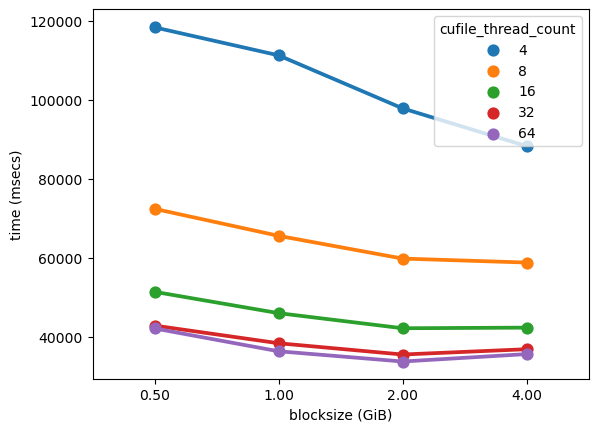

In [5]:
gds_df = measurements_df[
    measurements_df["GDS"]
]
g = sns.pointplot(
    data=gds_df,
    x="blocksize (GiB)",
    y="time (msecs)",
    hue=gds_df["cufile_thread_count"].astype(int),
    palette=sns.color_palette(n_colors=gds_df["cufile_thread_count"].nunique()),
    errorbar="se"
)
g.set_xticks(g.get_xticks(), labels=['{:.2f}'.format(float(t.get_text())) for t in g.get_xticklabels()])
plt.savefig(f"img/dask-gds-time.eps", format="eps", bbox_inches='tight')
plt.show()

## Comparison between GDS and non-GDS:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


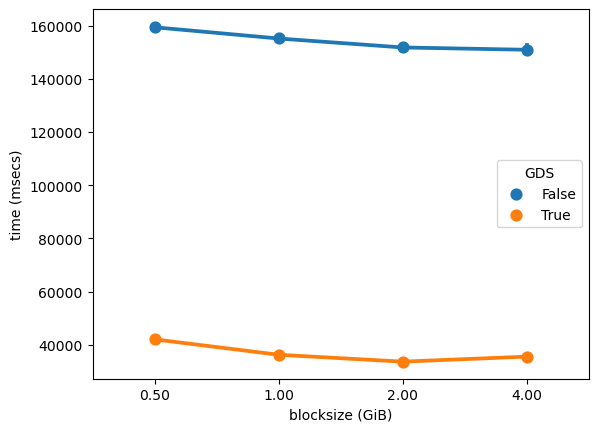

In [6]:
comparison_df = measurements_df[measurements_df.cufile_thread_count.isin([0, 64])]
g = sns.pointplot(
    data=comparison_df,
    x="blocksize (GiB)",
    y="time (msecs)",
    hue="GDS",
    palette=sns.color_palette(n_colors=2),
    errorbar="se"
)
g.set_xticks(g.get_xticks(), labels=['{:.2f}'.format(float(t.get_text())) for t in g.get_xticklabels()])
plt.savefig(f"img/dask-comparison-time.eps", format="eps", bbox_inches='tight')
plt.show()